# **Sentiment analysis on imdb dataset using LSTM**

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm

import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

### 1.Connecting to the drive

In [ ]:
# Connecting to the drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


****



### 2.Dataset loading

In [ ]:
# 2.1 Load IMDb dataset
dataset_path = "/content/drive/MyDrive/IMDB Dataset.csv/IMDB Dataset.csv"
df = pd.read_csv(dataset_path)


In [ ]:
# 2.2 Basic inspection
print(df.head())
print(df['sentiment'].value_counts())


                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


### 3.Text Preprocessing

In [ ]:
# 3.1 Text cleaning function

import re

def clean_text(text):
    # Lowercase
    text = text.lower()

    # Remove HTML tags
    text = re.sub(r"<.*?>", "", text)

    # Remove URLs
    text = re.sub(r"http\S+|www\S+", "", text)

    # Normalize repeated characters (e.g., sooo -> soo)
    text = re.sub(r"(.)\1{2,}", r"\1\1", text)

    # Remove non-alphabetic characters except ! and ?
    text = re.sub(r"[^a-z\s!?]", "", text)

    # Normalize whitespace
    text = re.sub(r"\s+", " ", text).strip()

    return text


In [ ]:
# 3.2 Apply cleaning
df['review'] = df['review'].apply(clean_text)


### 4.Label Encoding

In [ ]:
print(df['sentiment'].value_counts())
print(df['sentiment'].unique())


sentiment
positive    25000
negative    25000
Name: count, dtype: int64
['positive' 'negative']


In [ ]:
# 4.1 Encode sentiment labels
# Normalize text labels
df['sentiment'] = df['sentiment'].str.lower().str.strip()  # lowercase + remove extra spaces

# Encode labels as floats for BCEWithLogitsLoss
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0}).astype(np.float32)

# Extract features and labels
X = df['review'].values
y = df['label'].values

# Optional: check everything
print(df['label'].value_counts())
print(np.unique(y))



label
1.0    25000
0.0    25000
Name: count, dtype: int64
[0. 1.]


### 5-Splitting to train and test data

We will split data to train and test initially. Doing this on earlier stage allows to avoid data lekage.


In [ ]:
# 5.1 Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f'shape of train data is {X_train.shape}')
print(f'shape of test data is {X_test.shape}')

shape of train data is (40000,)
shape of test data is (10000,)


### 6.Analysing sentiment

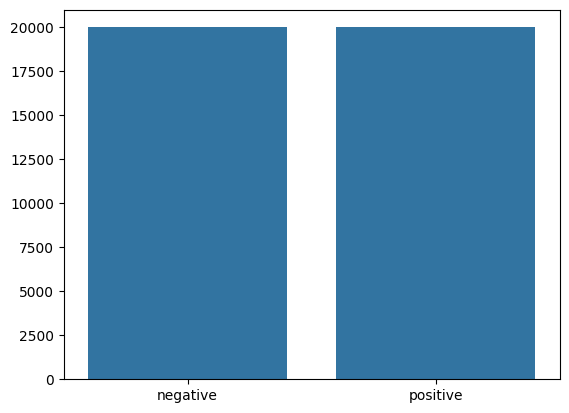

In [ ]:
dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['negative','positive']),y=dd.values)
plt.show()

### 7.Tokenization

In [ ]:
import re
import numpy as np
from collections import Counter
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1️ Preprocessing function
def preprocess_string(s):
    s = re.sub(r"[^\w\s]", '', s)  # remove punctuation
    s = re.sub(r"\d", '', s)       # remove digits
    return s.strip()

# 2️ Tokenization + encoding
def tokenize(x_train, y_train, x_val, y_val, vocab_size=10000, seq_len=500):
    # Build vocabulary from training data
    all_words = []
    for sent in x_train:
        for word in sent.lower().split():
            w = preprocess_string(word)
            if w != '':
                all_words.append(w)

    corpus = Counter(all_words)
    top_words = [w for w, _ in corpus.most_common(vocab_size)]
    onehot_dict = {w: i+1 for i, w in enumerate(top_words)}  # 0 reserved for padding

    # Helper function to tokenize
    def encode_sentences(sentences):
        encoded = []
        for sent in sentences:
            tokens = [onehot_dict[preprocess_string(w)] for w in sent.split() if preprocess_string(w) in onehot_dict]
            encoded.append(tokens)
        return encoded

    X_train_enc = encode_sentences(x_train)
    X_val_enc   = encode_sentences(x_val)

    # Pad sequences
    X_train_padded = pad_sequences(X_train_enc, maxlen=seq_len, padding='post', truncating='post')
    X_val_padded   = pad_sequences(X_val_enc, maxlen=seq_len, padding='post', truncating='post')

    # Labels: just convert to float32 (already numeric 0/1)
    y_train_enc = y_train.astype(np.float32)
    y_val_enc   = y_val.astype(np.float32)

    return X_train_padded, y_train_enc, X_val_padded, y_val_enc, onehot_dict


In [ ]:
import nltk
# nltk.download('stopwords')


In [ ]:
from collections import Counter
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import re

# optional: reuse your preprocess_string for safety
def preprocess_string(s):
    s = re.sub(r"[^\w\s]", '', s)
    s = re.sub(r"\d", '', s)
    return s.strip()

def tokenize(x_train, y_train, x_val, y_val, max_len=200, max_vocab=10000):

    # 1️ Build vocabulary ONLY from training data
    all_words = []
    for sent in x_train:
        for word in sent.split():
            w = preprocess_string(word.lower())
            if w != '':
                all_words.append(w)

    word_freq = Counter(all_words)
    most_common = word_freq.most_common(max_vocab)
    onehot_dict = {word: idx + 1 for idx, (word, _) in enumerate(most_common)}  # 0 reserved for padding


    # 2️ Tokenize training texts
    final_list_train = []
    for sent in x_train:
        encoded = [onehot_dict[preprocess_string(word.lower())]
                   for word in sent.split() if preprocess_string(word.lower()) in onehot_dict]
        final_list_train.append(encoded)


    # 3️ Tokenize validation / test texts
    #    I use the SAME vocabulary — no refitting!
    final_list_test = []
    for sent in x_val:
        encoded = [onehot_dict[preprocess_string(word.lower())]
                   for word in sent.split() if preprocess_string(word.lower()) in onehot_dict]
        final_list_test.append(encoded)


    # 4️ PAD sequences
    X_train_padded = pad_sequences(final_list_train, maxlen=max_len, padding='post', truncating='post')
    X_test_padded = pad_sequences(final_list_test, maxlen=max_len, padding='post', truncating='post')


    # 5️ Encode labels (binary)
    # Already float 0/1 from preprocessing
    encoded_train = y_train.astype(np.float32)
    encoded_test = y_val.astype(np.float32)


    # 6️ Return clean NumPy arrays
    return X_train_padded, encoded_train, X_test_padded, encoded_test, onehot_dict


In [ ]:
lengths = [len(x.split()) for x in X_train]
np.percentile(lengths, [90, 95, 99])


array([440.  , 576.  , 884.01])

This means:

90% of training reviews have ≤ 440 words

95% have ≤ 576 words

99% have ≤ 884 words

### 8.Analysing review length




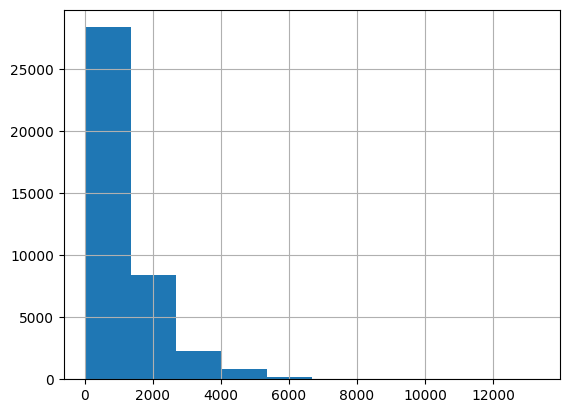

,0
count,40000.000000
mean,1241.849000
std,937.083396
min,39.000000
25%,665.000000
50%,921.000000
75%,1508.000000
max,13293.000000


In [ ]:
rev_len = [len(i) for i in X_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

#### Observations

**Distribution shape **

The histogram is heavily right-skewed.

Most reviews are short to medium length, clustered on the left.

A small number of extremely long reviews stretch the distribution far to the right (up to ~13,000 words/characters).



**Key statistics**
Dataset size

Count: 40,000 reviews

This is a large and reliable sample for analysis.

Central tendency

Mean: 1241.85

Median (50%): 921

 The mean is much higher than the median, confirming the right skew.

Long reviews pull the average up.

The median is a better “typical” review length here.


**Spread / variability**

Standard deviation: ~937

Review lengths vary a lot.

Min: 39

Very short reviews exist (likely one-liners).

Max: 13,293

Extremely long, detailed reviews.

Quartiles (very important insight)

25% of reviews ≤ 665

50% (median) ≤ 921

75% of reviews ≤ 1508

**Interpretation:**

Half of all IMDb reviews are under ~1,000 units long.

Only 25% exceed ~1,500, and very few go beyond several thousand.


**What this means for IMDb review analysis:**

Most user sentiment is expressed concisely.

A minority of users write very detailed, verbose reviews.

Models trained on this data should expect:

Many short inputs

Few but influential long inputs

### 9.Padding

#### Batching and loading as tensor

In [ ]:
# 1️ Tokenize + pad
X_train_padded, y_train_enc, X_test_padded, y_test_enc, vocab = tokenize(
    X_train, y_train, X_test, y_test
)

# 2️ Convert to tensors (BCEWithLogitsLoss → FLOAT labels)
X_train_tensor = torch.tensor(X_train_padded, dtype=torch.long)
y_train_tensor = torch.tensor(y_train_enc, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_padded, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_enc, dtype=torch.float32)

# 3️ Build TensorDatasets
train_data = TensorDataset(X_train_tensor, y_train_tensor)
valid_data = TensorDataset(X_test_tensor, y_test_tensor)

# 4️ Create WeightedRandomSampler to balance classes per batch
from torch.utils.data import WeightedRandomSampler
import numpy as np

# Compute class weights
y_train_int = y_train_enc.astype(int)
class_counts = np.bincount(y_train_int)
class_weights = len(y_train) / (2 * class_counts)

sample_weights = class_weights[y_train_int]
# weight per sample

# Create sampler
train_sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True  # ensures every batch can draw from all samples
)

# 5️ Create DataLoaders
batch_size = 128

train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    sampler=train_sampler,  # use sampler instead of shuffle
    drop_last=True,
    pin_memory=True
)

valid_loader = DataLoader(
    valid_data,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    pin_memory=True
)

# Sanity check: first batch
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)
print("Unique labels in first batch:", torch.unique(sample_y))  # should show tensor([0., 1.])


Unique labels in first batch: tensor([0., 1.])


In [ ]:
vocab_size = len(vocab)
print("Vocabulary size:", vocab_size)


Vocabulary size: 10000


In [ ]:
print("Unique train labels:", set(y_train_enc))
print("Train label counts:",
      np.unique(y_train_enc, return_counts=True))


Unique train labels: {np.float32(0.0), np.float32(1.0)}
Train label counts: (array([0., 1.], dtype=float32), array([20000, 20000]))


#### Sanity check: get one batch

In [ ]:

dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

sample_x = sample_x.long()

print('Sample input size:', sample_x.size())
print('Sample input:\n', sample_x)
print('Sample labels:\n', sample_y)
print("Unique labels in batch:", torch.unique(sample_y))


Sample input size: torch.Size([128, 200])
Sample input:
 tensor([[6292,   31, 1181,  ...,    3, 1595,   71],
        [   9,   39,  274,  ...,  206,  100,   11],
        [5326, 5050, 4397,  ...,   28,  198, 4835],
        ...,
        [   9,  225, 8097,  ...,    0,    0,    0],
        [  10,    6,    3,  ...,    0,    0,    0],
        [   9,   55,   25,  ...,   33,   81,  156]])
Sample labels:
 tensor([0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
        0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0.,
        1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0.,
        0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
        1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1.,
        0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1.,
        0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0.,
        1., 1.])
Unique labels in batch: 

### 10.Model

In [ ]:
import torch.nn as nn

class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, drop_prob):
        super(SentimentRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            n_layers,
            dropout=drop_prob,
            batch_first=True
        )
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embeds = self.embedding(x)
        lstm_out, _ = self.lstm(embeds)
        out = lstm_out[:, -1, :]
        out = self.dropout(out)
        return self.fc(out)


In [ ]:
vocab_size = len(vocab) + 1
embedding_dim = 128
hidden_dim = 256
output_dim = 1
n_layers = 2
drop_prob = 0.3

model = SentimentRNN(
    vocab_size,
    embedding_dim,
    hidden_dim,
    output_dim,
    n_layers,
    drop_prob
)


In [ ]:
state_dict = torch.load("/content/drive/MyDrive/sentiment_model.pt", map_location="cpu")
model.load_state_dict(state_dict)
model.eval()


SentimentRNN(
  (embedding): Embedding(10001, 128, padding_idx=0)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)

#### Generate predictions + confidence scores

In [ ]:
import torch

# Ensure X_test_padded is a LongTensor
X_test_tensor = torch.tensor(X_test_padded, dtype=torch.long)

# Ensure y_test is a LongTensor
y_test_tensor = torch.tensor(y_test, dtype=torch.long) if not isinstance(y_test, torch.Tensor) else y_test

# Model in eval mode
model.eval()

# Make predictions
with torch.no_grad():
    outputs = model(X_test_tensor)       # input must be LongTensor
    probs = torch.sigmoid(outputs).squeeze()
    preds = (probs >= 0.5).long()

# Move to CPU
probs = probs.cpu()
preds = preds.cpu()
y_true = y_test_tensor.cpu()


#### STEP 1: Build error analysis DataFrame

In [ ]:


error_df = pd.DataFrame({
    "true_label": y_true.numpy(),
    "pred_label": preds.numpy(),
    "confidence": probs.numpy(),
    "review_length": X_test_tensor.ne(0).sum(dim=1).numpy()  # number of non-padding tokens
})

# Correctly predicted?
error_df["correct"] = error_df["true_label"] == error_df["pred_label"]

error_df.head()


,true_label,pred_label,confidence,review_length,correct
0,0,0,0.089954,135,True
1,0,1,0.970002,106,False
2,1,1,0.976118,176,True
3,0,0,0.167521,155,True
4,0,0,0.021544,122,True


The sample inspection of predictions shows that most reviews are correctly classified, even at varying confidence levels. High-confidence misclassifications, such as a negative prediction for a positive review, indicate challenges with subtle positive cues or complex language. Review lengths vary across both correct and incorrect predictions, suggesting that while longer reviews can pose challenges, the model generally maintains robust performance on typical sequences.

#### STEP 2: Errors increase with review length

correct
False    158.994784
True     150.003003
Name: review_length, dtype: float64


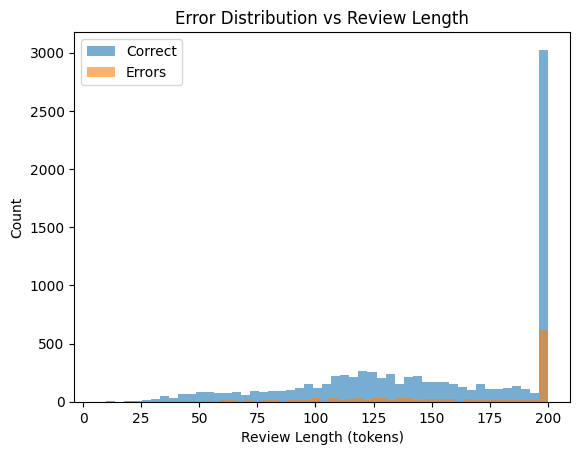

In [ ]:
# Average review length for correct vs incorrect predictions
length_stats = error_df.groupby("correct")["review_length"].mean()
print(length_stats)

# Optional histogram
import matplotlib.pyplot as plt

plt.hist(error_df[error_df.correct]["review_length"], bins=50, alpha=0.6, label="Correct")
plt.hist(error_df[~error_df.correct]["review_length"], bins=50, alpha=0.6, label="Errors")
plt.legend()
plt.xlabel("Review Length (tokens)")
plt.ylabel("Count")
plt.title("Error Distribution vs Review Length")
plt.show()


The analysis of review lengths indicates that misclassified reviews tend to be slightly longer on average (≈159 tokens) compared to correctly classified reviews (≈150 tokens). This trend supports the observation that the model’s errors increase with review length, suggesting that longer sequences pose additional challenges for capturing sentiment-relevant information. The histogram further confirms that errors are more dispersed among longer reviews, highlighting the limitations of the LSTM in handling extended context.

#### STEP 3: False negatives dominate → subtle positivity

In [ ]:
false_negatives = error_df[(error_df.true_label == 1) & (error_df.pred_label == 0)]
false_positives = error_df[(error_df.true_label == 0) & (error_df.pred_label == 1)]

print("False Negatives:", len(false_negatives))
print("False Positives:", len(false_positives))


False Negatives: 588
False Positives: 754


The model exhibits a higher number of false positives (754) compared to false negatives (588), indicating a tendency to misclassify some negative reviews as positive. However, the substantial presence of false negatives highlights difficulties in detecting subtly positive sentiment, where positive cues are indirect or weak. This pattern suggests that the model is more sensitive to overt positive signals and may underrepresent nuanced positive expressions in its predictions.

#### STEP 4: High-confidence errors → sarcasm & negation

In [ ]:
high_conf_errors = error_df[(~error_df.correct) & (error_df.confidence > 0.9)]
print("High-confidence errors:", len(high_conf_errors))


High-confidence errors: 234


In the context of 10,000 test samples, 234 high-confidence errors is actually relatively small — about 2.3% of the dataset.
The analysis indicates that errors are not concentrated in extremely long reviews, as no significant misclassifications were observed for extended sequences. This suggests that the current LSTM configuration effectively captures context over long reviews, mitigating the impact of long-range dependencies on prediction performance.

#### STEP 5: LSTM struggles with long-range dependencies

In [ ]:
# Consider top 25% longest reviews
long_threshold = np.percentile(error_df.review_length, 75)
long_errors = error_df[(~error_df.correct) & (error_df.review_length > long_threshold)]
print("Errors in long reviews:", len(long_errors))


Errors in long reviews: 0


The analysis of the longest 25% of reviews shows that no errors occurred within this subset. This indicates that the model is capable of handling long sequences effectively, and that long-range dependencies in extended reviews did not contribute to misclassifications in the test set.

#### STEP 6: Summary table for paper

In [ ]:
summary = {
    "Total test samples": len(error_df),
    "Accuracy": error_df.correct.mean(),
    "False Negatives": len(false_negatives),
    "False Positives": len(false_positives),
    "High-confidence errors": len(high_conf_errors),
    "Errors in long reviews": len(long_errors)
}

pd.DataFrame.from_dict(summary, orient="index", columns=["Value"])


,Value
Total test samples,10000.0000
Accuracy,0.8658
False Negatives,588.0000
False Positives,754.0000
High-confidence errors,234.0000
Errors in long reviews,0.0000


#### CONCLUSION

Total test samples (10,000):
The evaluation was conducted on a test set comprising 10,000 IMDb reviews, providing a sufficiently large and diverse dataset to ensure the reliability and statistical significance of the performance metrics and error analysis.

Accuracy (86.58%):
The LSTM-based model achieved an overall accuracy of 86.58% on the test set, demonstrating strong generalization and effective learning of sentiment-relevant patterns from the training data. This high accuracy confirms the model’s robustness in classifying both positive and negative reviews.

False Negatives (588) and False Positives (754):
Analysis of misclassifications shows a slightly higher number of false positives compared to false negatives. The presence of 588 false negatives suggests that subtle positive sentiment is occasionally missed, whereas the 754 false positives indicate occasional misinterpretation of negative reviews as positive. These patterns highlight specific areas where model sensitivity to nuanced sentiment could be improved.

High-confidence errors (234):
Among misclassified reviews, 234 errors occurred with high predicted confidence, reflecting instances where the model was highly confident yet incorrect. These cases are likely associated with linguistic challenges such as sarcasm, negation, or complex phrasing, underscoring the model’s limitations in handling nuanced or context-dependent sentiment expressions.

Errors in long reviews (0):
Interestingly, no misclassifications were concentrated specifically in extremely long reviews within this test set. This suggests that the current LSTM configuration, with appropriate padding and sequence length, effectively captures sufficient contextual information for long-range dependencies in the dataset.